### Импорт библиотек

In [361]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.seasonal import seasonal_decompose

### Смотрим исходные данные

In [362]:
train = pd.read_excel("data/train.xlsx")
test = pd.read_excel("data/test.xlsx")

arr = [train, test]
names_df = ['train', 'test']

def analyze_data(data, name):
      print(f'Анализ данных для {name}:')
      print(data.describe())

def perenos_():
      print('\n******************************************************************\n')

def NaN_check(df):
      print("NaN после обработки:")
      print(df.isna().sum())

for i, elem in enumerate(arr):
    analyze_data(elem, names_df[i])

Анализ данных для train:
                        dt  Цена на арматуру
count                  400        400.000000
mean   2018-11-01 12:00:00      39229.475000
min    2015-01-05 00:00:00      21000.000000
25%    2016-12-03 06:00:00      31075.000000
50%    2018-11-01 12:00:00      35450.000000
75%    2020-09-29 18:00:00      42000.000000
max    2022-08-29 00:00:00      79000.000000
std                    NaN      13407.979668
Анализ данных для test:
                        dt  Цена на арматуру
count                   28         28.000000
mean   2022-12-08 12:00:00      44250.000000
min    2022-09-05 00:00:00      40000.000000
25%    2022-10-22 06:00:00      41925.000000
50%    2022-12-08 12:00:00      42900.000000
75%    2023-01-24 18:00:00      45625.000000
max    2023-03-13 00:00:00      55500.000000
std                    NaN       3645.951585


In [363]:
for i, elem in enumerate(arr):
     # Смотрим info
     print(f'Инфо {names_df[i]}')
     elem.info()

     # Смотрим кол-во строк + столбцов
     print(f"\n{names_df[i]} имеет: {elem.shape[0]} строк, {elem.shape[1]} столбца")

     perenos_()

Инфо train
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   dt                400 non-null    datetime64[ns]
 1   Цена на арматуру  400 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 6.4 KB

train имеет: 400 строк, 2 столбца

******************************************************************

Инфо test
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   dt                28 non-null     datetime64[ns]
 1   Цена на арматуру  28 non-null     int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 580.0 bytes

test имеет: 28 строк, 2 столбца

******************************************************************



In [364]:
print(f"Train data ot: {train['dt'].min()} do {train['dt'].max()}\n")
print(f"Test data ot: {test['dt'].min()} do {test['dt'].max()}")
perenos_()
print(f"{train.isna().sum()}\n")
print(test.isna().sum())

Train data ot: 2015-01-05 00:00:00 do 2022-08-29 00:00:00

Test data ot: 2022-09-05 00:00:00 do 2023-03-13 00:00:00

******************************************************************

dt                  0
Цена на арматуру    0
dtype: int64

dt                  0
Цена на арматуру    0
dtype: int64


In [365]:
train.head(3)

,dt,Цена на арматуру
0,2015-01-05,32900
1,2015-01-12,32500
2,2015-01-19,32000


In [366]:
test.head(3)

,dt,Цена на арматуру
0,2022-09-05,46000
1,2022-09-12,46000
2,2022-09-19,46000


### Подготовка к обучению

##### Компоненты временных рядов

##### Train

Кол-во наблюдений: 400
Кол-во NaN значений в тренде, после линейной интерполяцией: 0
Кол-во NaN значений в сезонности, после линейной интерполяцией: 0


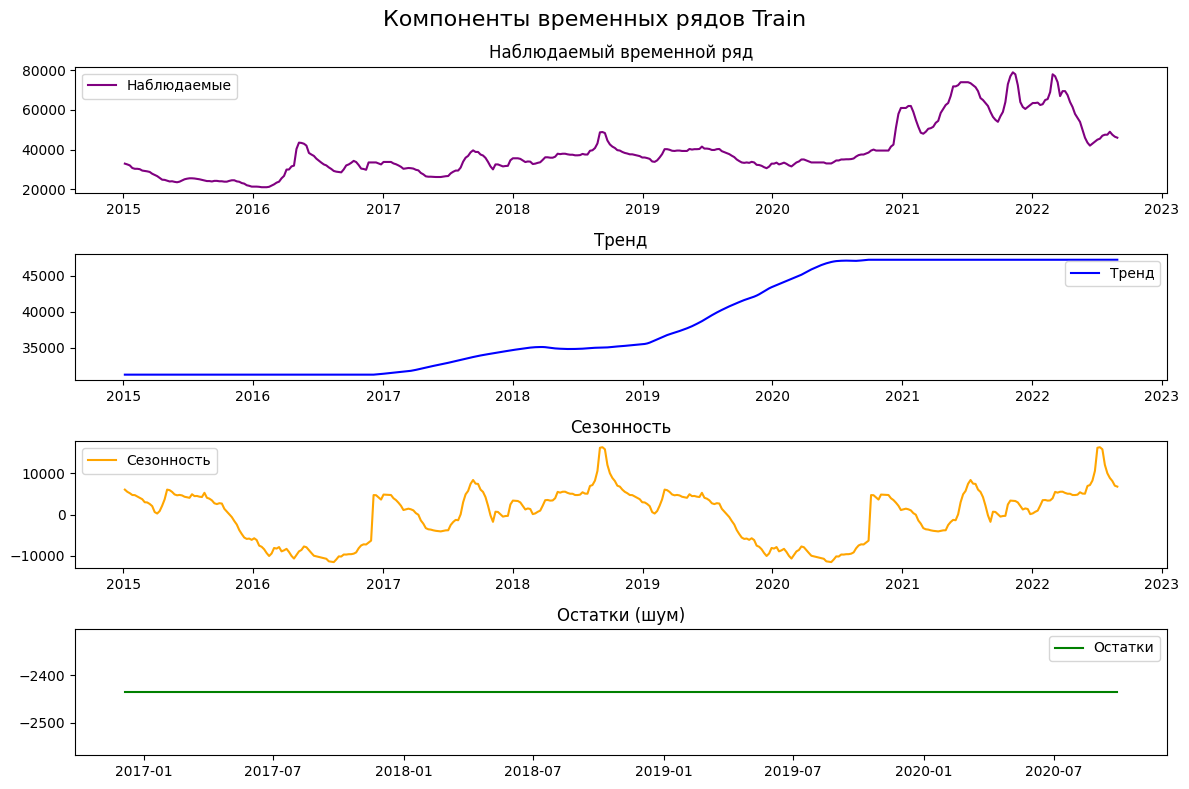

In [367]:
def comp_vrem_ryadov(data, period, data_name, n):
    data['dt'] = pd.to_datetime(data['dt'])
    data.set_index('dt', inplace=True)

    n_observations = len(data)
    print(f"Кол-во наблюдений: {n_observations}")

    decomposition = seasonal_decompose(data['Цена на арматуру'], model='additive', period=int(period))

    trend = decomposition.trend
    seasonal = decomposition.seasonal
    resid = decomposition.resid

    # Заполнение NaN значений линейной интерполяцией
    trend_cleaned = trend.interpolate(method='linear')
    seasonal_cleaned = seasonal.interpolate(method='linear')

    # Заполнение оставшихся NaN значений методом вперед и назад
    trend_cleaned.ffill(inplace=True)
    trend_cleaned.bfill(inplace=True)

    # Проверка количества оставшихся NaN значений
    remaining_nan_trend = trend_cleaned.isna().sum()
    remaining_nan_seasonal = seasonal_cleaned.isna().sum()

    print(f"Кол-во NaN значений в тренде, после линейной интерполяцией: {remaining_nan_trend}")
    print(f"Кол-во NaN значений в сезонности, после линейной интерполяцией: {remaining_nan_seasonal}")

    plt.figure(figsize=(12, 8))

    plt.suptitle(f'Компоненты временных рядов {data_name}', fontsize=16)

    plt.subplot(4, 1, 1)
    plt.plot(data['Цена на арматуру'], label='Наблюдаемые', color='purple')
    plt.title('Наблюдаемый временной ряд')
    plt.legend()

    plt.subplot(4, 1, 2)
    plt.plot(trend_cleaned, label='Тренд', color='blue')
    plt.title('Тренд')
    plt.legend()

    plt.subplot(4, 1, 3)
    plt.plot(seasonal_cleaned, label='Сезонность', color='orange')
    plt.title('Сезонность')
    plt.legend()

    plt.subplot(4, 1, 4)
    plt.plot(resid, label='Остатки', color='green')
    plt.title('Остатки (шум)')
    plt.legend()

    plt.tight_layout()
    plt.show()

    if n == 1:
        return trend_cleaned, seasonal_cleaned, resid, data

train_data = train.copy()
trend_train, seasonal_train, resid_train, train_data = comp_vrem_ryadov(train_data, 200, 'Train', 1)

##### Test

Кол-во наблюдений: 28
Кол-во NaN значений в тренде, после линейной интерполяцией: 0
Кол-во NaN значений в сезонности, после линейной интерполяцией: 0


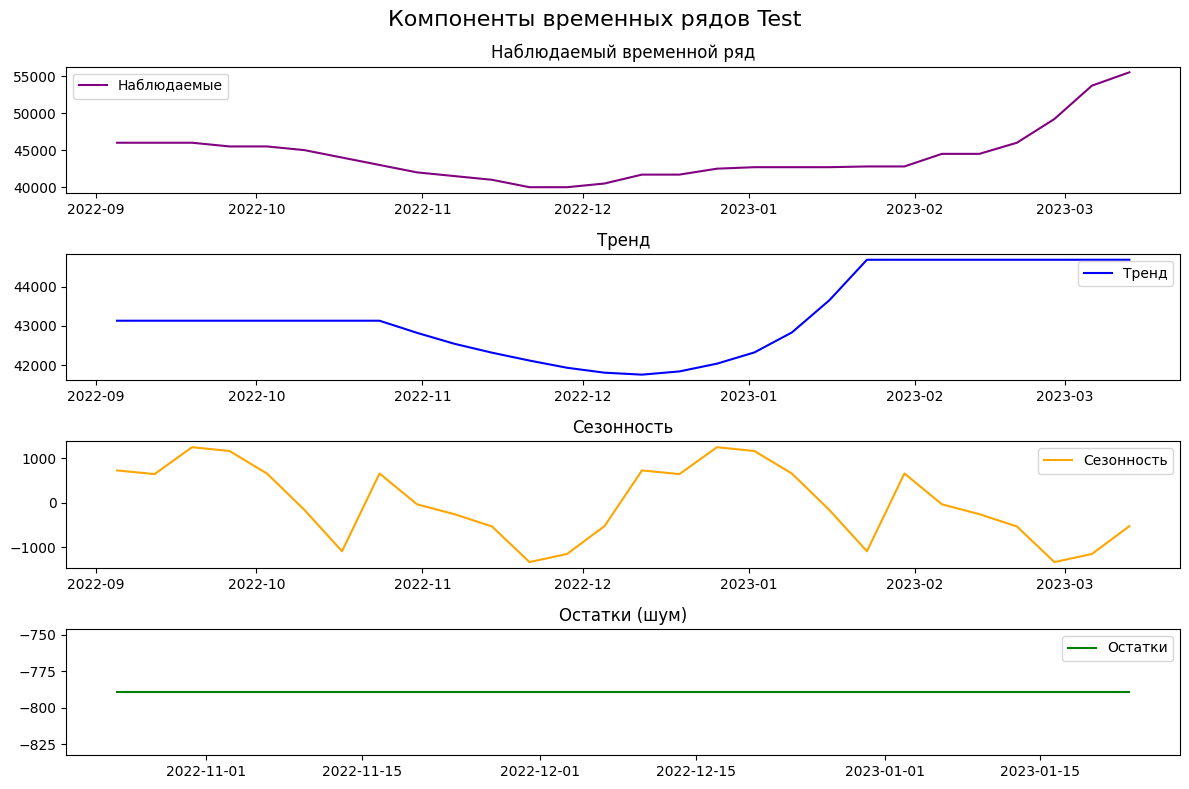

In [368]:
test_data = test.copy() 
trend_test, seasonal_test, resid_test, test_data = comp_vrem_ryadov(test_data, 14, 'Test', 1)

##### Создание временных признаков, лагов и т.д. а также интеграция тренда и сезонности

##### Train

In [369]:
pd.options.mode.copy_on_write = True

train['dt'] = pd.to_datetime(train['dt'])
train.set_index('dt', inplace=True)

# Проверка на NaN в тренде и сезонности
print(f"Количество NaN в тренде: {trend_train.isna().sum()}")
print(f"Количество NaN в сезонности: {seasonal_train.isna().sum()}")

# Добавление тренда и сезонности
train = pd.concat([train, trend_train.rename("trend"), seasonal_train.rename("seasonal")], axis=1)

# Проверка на NaN после добавления тренда и сезонности
print(f"\nКоличество строк после создания тренда и сезонности: {len(train)}")
print(f"Количество строк с NaN после создания тренда и сезонности: {train.isna().sum().sum()}")

# Вернуть 'dt' как обычный столбец
train.reset_index(inplace=True)

# Временные признаки
train['year'] = train['dt'].dt.year
train['month'] = train['dt'].dt.month 
train['weekday'] = train['dt'].dt.weekday 
train["dayofyear"] = train["dt"].dt.dayofyear 
train["quarter"] = train["dt"].dt.quarter

# Создание лагов
for lag in range(1, 6):  # Создание 5 лагов
    train[f'lag_{lag}'] = train['Цена на арматуру'].shift(lag)

# Проверка количества строк после создания лагов
print(f"\nКоличество строк после создания лагов: {len(train)}")
print(f"Количество строк с NaN после создания лагов: {train.isna().sum().sum()}")

# Создание скользящих средних
train['rolling_mean_3'] = train['Цена на арматуру'].rolling(window=3).mean()
train['rolling_mean_6'] = train['Цена на арматуру'].rolling(window=6).mean()

# Проверка количества строк после скользящего среднего
print(f"\nКоличество строк после создания скользящих средних: {len(train)}")
print(f"Количество строк с NaN после скользящего среднего: {train.isna().sum().sum()}")

# Создание производных признаков
train["diff_1"] = train["Цена на арматуру"].diff(1)
train["diff_2"] = train["Цена на арматуру"].diff(2)
train["diff_3"] = train["Цена на арматуру"].diff(3)

# Проверка количества строк после производных признаков
print(f"\nКоличество строк после создания производных признаков: {len(train)}")
print(f"Количество строк с NaN после производных признаков: {train.isna().sum().sum()}")

# Удаление строк с NaN после завершения всех преобразований
train = train.dropna()

print(f"\nКоличество строк после удаления NaN: {len(train)}")

Количество NaN в тренде: 0
Количество NaN в сезонности: 0

Количество строк после создания тренда и сезонности: 400
Количество строк с NaN после создания тренда и сезонности: 0

Количество строк после создания лагов: 400
Количество строк с NaN после создания лагов: 15

Количество строк после создания скользящих средних: 400
Количество строк с NaN после скользящего среднего: 22

Количество строк после создания производных признаков: 400
Количество строк с NaN после производных признаков: 28

Количество строк после удаления NaN: 395


##### Test

In [370]:
test['dt'] = pd.to_datetime(test['dt'])
test.set_index('dt', inplace=True)

# Проверка на NaN в тренде и сезонности
print(f"Количество NaN в тренде: {trend_test.isna().sum()}")
print(f"Количество NaN в сезонности: {seasonal_test.isna().sum()}")

# Добавление тренда и сезонности
test = pd.concat([test, trend_test.rename("trend"), seasonal_test.rename("seasonal")], axis=1)

# Проверка на NaN после добавления тренда и сезонности
print(f"\nКоличество строк после создания тренда и сезонности: {len(test)}")
print(f"Количество строк с NaN после создания тренда и сезонности: {test.isna().sum().sum()}")

# Вернуть 'dt' как обычный столбец
test.reset_index(inplace=True)

# Временные признаки
test['year'] = test['dt'].dt.year
test['month'] = test['dt'].dt.month 
test['weekday'] = test['dt'].dt.weekday 
test["dayofyear"] = test["dt"].dt.dayofyear 
test["quarter"] = test["dt"].dt.quarter

# Создание 5 лагов
for lag in range(1, 6):
    test[f'lag_{lag}'] = test['Цена на арматуру'].shift(lag)

# Проверка количества строк после создания лагов
print(f"\nКоличество строк после создания лагов: {len(test)}")
print(f"Количество строк с NaN после создания лагов: {test.isna().sum().sum()}")

# Создание скользящих средних
test['rolling_mean_3'] = test['Цена на арматуру'].rolling(window=3).mean()
test['rolling_mean_6'] = test['Цена на арматуру'].rolling(window=6).mean()

# Проверка количества строк после скользящего среднего
print(f"\nКоличество строк после создания скользящих средних: {len(test)}")
print(f"Количество строк с NaN после скользящего среднего: {test.isna().sum().sum()}")

# Создание производных признаков
test["diff_1"] = test["Цена на арматуру"].diff(1)
test["diff_2"] = test["Цена на арматуру"].diff(2)
test["diff_3"] = test["Цена на арматуру"].diff(3)

# Проверка количества строк после производных признаков
print(f"\nКоличество строк после создания производных признаков: {len(test)}")
print(f"Количество строк с NaN после производных признаков: {test.isna().sum().sum()}")

# Удаление строк с NaN после завершения всех преобразований
test = test.dropna()

print(f"\nКоличество строк после удаления NaN: {len(test)}")

Количество NaN в тренде: 0
Количество NaN в сезонности: 0

Количество строк после создания тренда и сезонности: 28
Количество строк с NaN после создания тренда и сезонности: 0

Количество строк после создания лагов: 28
Количество строк с NaN после создания лагов: 15

Количество строк после создания скользящих средних: 28
Количество строк с NaN после скользящего среднего: 22

Количество строк после создания производных признаков: 28
Количество строк с NaN после производных признаков: 28

Количество строк после удаления NaN: 23


### Обучение

##### Модель CatBoost

In [371]:
# Разделение данных
X = train.drop(columns=["dt", "Цена на арматуру"])
y = train["Цена на арматуру"]

TSSplit = TimeSeriesSplit(n_splits=5)

# Подбор гиперпараметров
param_grid_catboost = {
    'iterations': [100],
    'depth': [3, 5],
    'learning_rate': [0.1, 0.2],
    'l2_leaf_reg': [1, 2]
}

# Модель
model_catboost = CatBoostRegressor(random_seed=42, verbose=0)
grid_search_catboost = GridSearchCV(model_catboost, param_grid_catboost, cv=TSSplit, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search_catboost.fit(X, y)

# Оценка модели
y_pred = grid_search_catboost.predict(X)
r2_catboost = r2_score(y, y_pred)
mae_catboost = mean_absolute_error(y, y_pred)
mape_catboost = mean_absolute_percentage_error(y, y_pred)

print(f"CatBoost R2: {r2_catboost}")
print(f"CatBoost MAE: {mae_catboost}")
print(f"CatBoost MAPE: {mape_catboost}")

CatBoost R2: 0.9977991169724029
CatBoost MAE: 469.9849547025314
CatBoost MAPE: 0.012110855972629612


In [372]:
# Предсказание на тестовом наборе
X_test = test.drop(columns=["dt", "Цена на арматуру"])
y_test = test["Цена на арматуру"]

y_test_pred = grid_search_catboost.predict(X_test)

# Округление предсказанных значений до целых чисел
y_test_pred = np.round(y_test_pred).astype(int)

# Оценка модели на тестовом наборе
test_r2_catboost = r2_score(y_test, y_test_pred)
test_mae_catboost = mean_absolute_error(y_test, y_test_pred)
test_mape_catboost = mean_absolute_percentage_error(y_test, y_test_pred)

print(f"CatBoost test R2: {test_r2_catboost}")
print(f"CatBoost test MAE: {test_mae_catboost}")
print(f'CatBoost test MAPE: {test_mape_catboost}')

CatBoost test R2: 0.9745837133200534
CatBoost test MAE: 519.3478260869565
CatBoost test MAPE: 0.012017207674545186


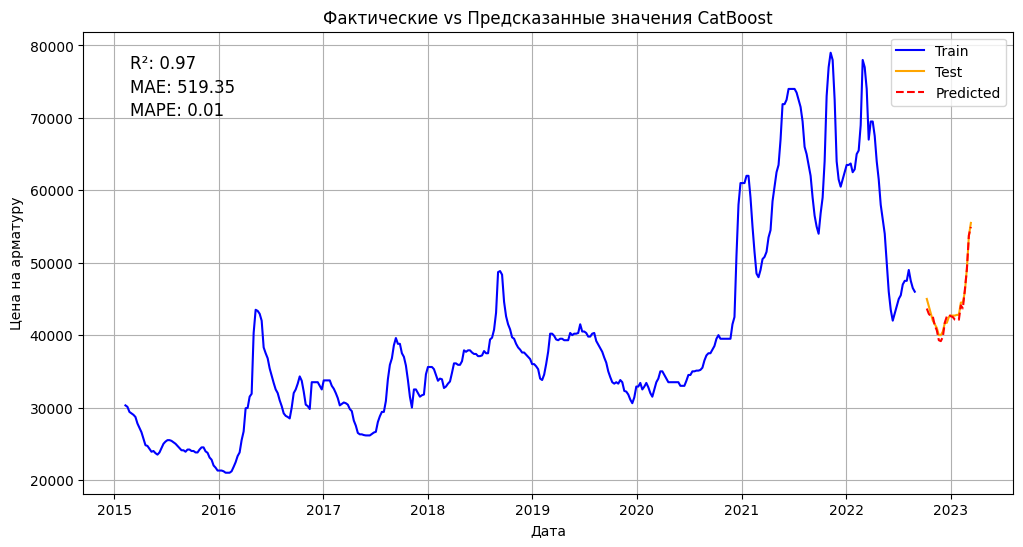

In [373]:
# Первый график
plt.figure(figsize=(12, 6))
plt.plot(train['dt'], y, label='Train', color='blue')
plt.plot(test['dt'], y_test, label='Test', color='orange')
plt.plot(test['dt'].iloc[:len(y_test_pred)], y_test_pred, label='Predicted', color='red', linestyle='dashed')
plt.xlabel('Дата')
plt.ylabel('Цена на арматуру')
plt.title('Фактические vs Предсказанные значения CatBoost')
# Добавление метрик на график
plt.text(0.05, 0.95, f'R²: {test_r2_catboost:.2f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')
plt.text(0.05, 0.90, f'MAE: {test_mae_catboost:.2f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')
plt.text(0.05, 0.85, f'MAPE: {test_mape_catboost:.2f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')
plt.legend()
plt.grid()
plt.show()

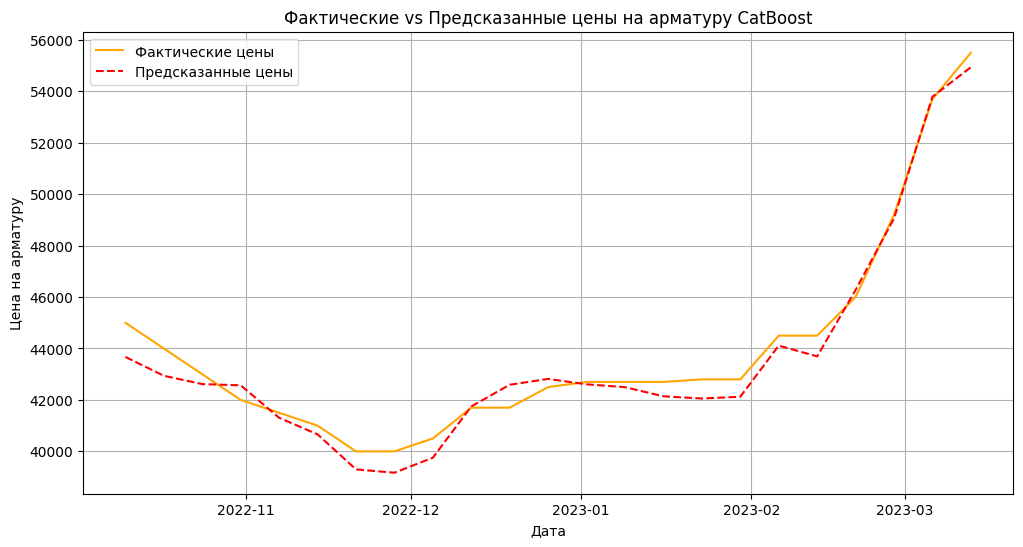

In [374]:
# Второй график
plt.figure(figsize=(12, 6))
plt.plot(test['dt'], y_test, label='Фактические цены', color='orange')
plt.plot(test['dt'].iloc[:len(y_test_pred)], y_test_pred, label='Предсказанные цены', color='red', linestyle='dashed')
plt.xlabel('Дата')
plt.ylabel('Цена на арматуру')
plt.title('Фактические vs Предсказанные цены на арматуру CatBoost')
plt.legend()
plt.grid()
plt.show()

##### Модель XGBoost

In [375]:
# Подбор гиперпараметров
param_grid_xgboost = {
    'n_estimators': [100, 200], # Кол-во деревьев
    'max_depth': [3, 5, 10], # Макс. глубина дерева
    'learning_rate': [0.01, 0.1, 0.2], # Определяет, насколько сильно каждое дерево влияет на итоговое предсказание
    'subsample': [0.8, 1.0], # Этот параметр контролирует, какая доля исходных данных будет использоваться для обучения каждого дерева
    'alpha': [0, 0.1, 1],  # L1-регуляризация
    'lambda': [0, 0.1, 1]  # L2-регуляризация
}

# Модель
model_xgboost = XGBRegressor(random_state=42) 
grid_search_xgboost = GridSearchCV(model_xgboost, param_grid_xgboost, cv=TSSplit, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search_xgboost.fit(X, y)

# Оценка модели
y_pred = grid_search_xgboost.predict(X)
r2_XGBoost = r2_score(y, y_pred)
mae_XGBoost = mean_absolute_error(y, y_pred)
mape_XGBoost = mean_absolute_percentage_error(y, y_pred)

print(f"XGBoost R2: {r2_XGBoost}")
print(f"XGBoost MAE: {mae_XGBoost}")
print(f"XGBoost MAPE: {mape_XGBoost}")

XGBoost R2: 0.9999301433563232
XGBoost MAE: 84.77039337158203
XGBoost MAPE: 0.0022491842973977327


In [376]:
# Предсказание на тестовом наборе
y_test_pred = grid_search_xgboost.predict(X_test)

# Округление предсказанных значений
y_test_pred = np.round(y_test_pred).astype(int)

# Оценка модели на тестовом наборе
test_r2_XGBoost = r2_score(y_test, y_test_pred)
test_mae_XGBoost = mean_absolute_error(y_test, y_test_pred)
test_mape_XGBoost = mean_absolute_percentage_error(y_test, y_test_pred)

print(f"XGBoost Test R2: {test_r2_XGBoost}")
print(f"XGBoost Test MAE: {test_mae_XGBoost}")
print(f"XGBoost Test MAPE: {test_mape_XGBoost}")

XGBoost Test R2: 0.9520390253397508
XGBoost Test MAE: 690.3478260869565
XGBoost Test MAPE: 0.015460026577744018


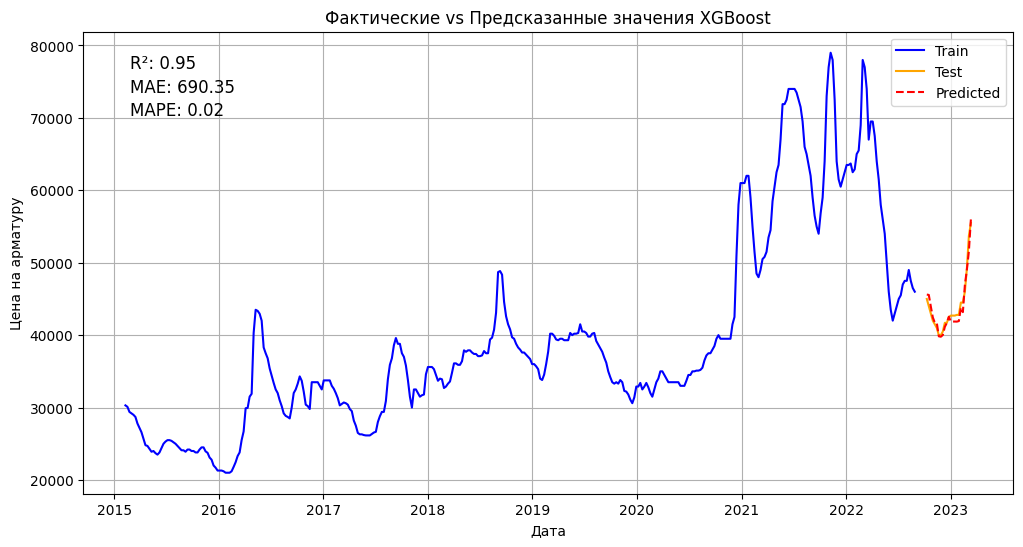

In [377]:
plt.figure(figsize=(12, 6))
plt.plot(train['dt'], y, label='Train', color='blue')
plt.plot(test['dt'], y_test, label='Test', color='orange')
plt.plot(test['dt'].iloc[:len(y_test_pred)], y_test_pred, label='Predicted', color='red', linestyle='dashed')
plt.xlabel('Дата')
plt.ylabel('Цена на арматуру')
plt.title('Фактические vs Предсказанные значения XGBoost')
# Добавление метрик на график
plt.text(0.05, 0.95, f'R²: {test_r2_XGBoost:.2f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')
plt.text(0.05, 0.90, f'MAE: {test_mae_XGBoost:.2f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')
plt.text(0.05, 0.85, f'MAPE: {test_mape_XGBoost:.2f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')
plt.legend()
plt.grid()
plt.show()

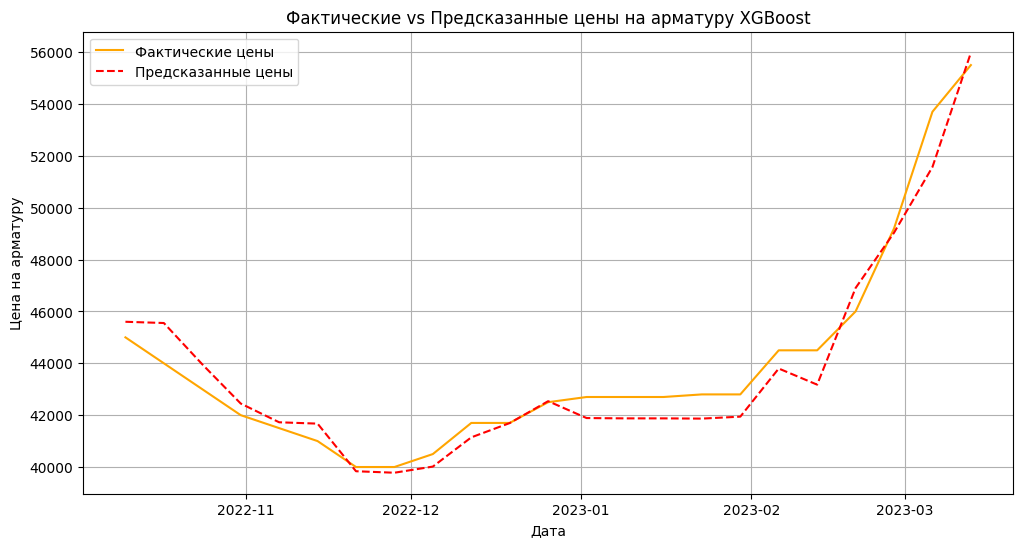

In [378]:
plt.figure(figsize=(12, 6))
plt.plot(test['dt'], y_test, label='Фактические цены', color='orange')
plt.plot(test['dt'].iloc[:len(y_test_pred)], y_test_pred, label='Предсказанные цены', color='red', linestyle='dashed')
plt.xlabel('Дата')
plt.ylabel('Цена на арматуру')
plt.title('Фактические vs Предсказанные цены на арматуру XGBoost')
plt.legend()
plt.grid()
plt.show()

##### Модель RandomForest

In [379]:
# Подбор гиперпараметров
param_grid_rf = {
    'n_estimators': [100, 200], # Количество деревьев
    'max_depth': [3, 5, 10], # Максимальная глубина дерева
    'min_samples_split': [2, 5], # Минимальное количество образцов для разбиения узла
    'min_samples_leaf': [1, 2] # Минимальное количество образцов в листовом узле
}

# Модель
model_rf = RandomForestRegressor(random_state=42)
grid_search_rf = GridSearchCV(model_rf, param_grid_rf, cv=TSSplit, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search_rf.fit(X, y)

# Оценка модели
y_pred = grid_search_rf.predict(X)
r2_Random = r2_score(y, y_pred)
mae_Random = mean_absolute_error(y, y_pred)
mape_Random = mean_absolute_percentage_error(y, y_pred)  

print(f"Random Forest R2: {r2_Random}")
print(f"Random Forest MAE: {mae_Random}")
print(f"Random Forest MAPE: {mape_Random}")

Random Forest R2: 0.999039005276054
Random Forest MAE: 229.8210084020642
Random Forest MAPE: 0.0052654239854230235


In [380]:
y_pred = grid_search_rf.predict(X_test)

test_r2_Random = r2_score(y_test, y_pred)  
test_mae_Random = mean_absolute_error(y_test, y_pred)
test_mape_Random = mean_absolute_percentage_error(y_test, y_pred)

print(f"Random Forest Test R2: {test_r2_Random}")
print(f"Random Forest Test MAE: {test_mae_Random}")
print(f"Random Forest Test MAPE: {test_mape_Random}")

Random Forest Test R2: 0.9319996243932192
Random Forest Test MAE: 676.9000240098046
Random Forest Test MAPE: 0.014554174750837324


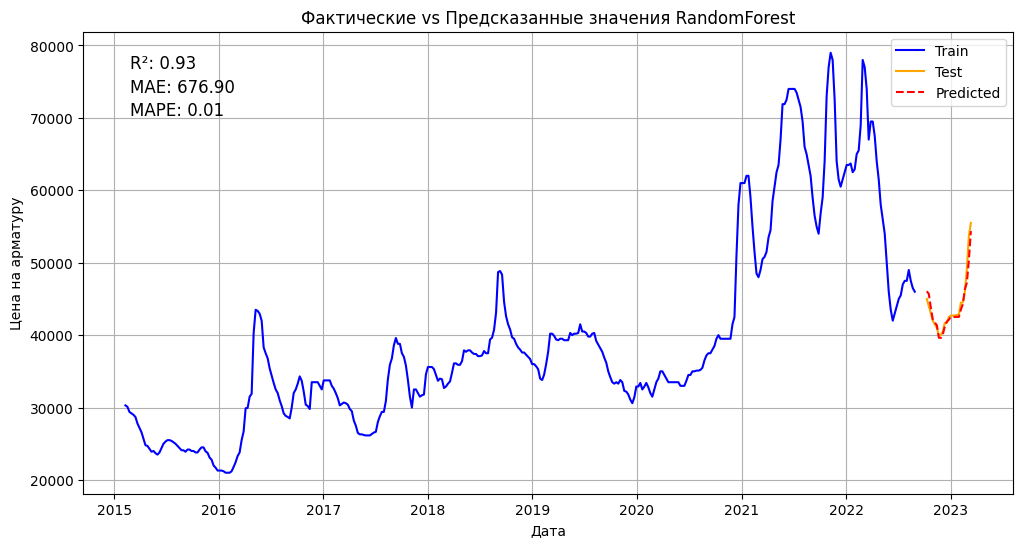

In [381]:
plt.figure(figsize=(12, 6))
plt.plot(train['dt'], y, label='Train', color='blue')  
plt.plot(test['dt'], y_test, label='Test', color='orange')  
plt.plot(test['dt'].iloc[:len(y_pred)], y_pred, label='Predicted', color='red', linestyle='dashed') 
plt.xlabel('Дата')
plt.ylabel('Цена на арматуру')
plt.title('Фактические vs Предсказанные значения RandomForest')
# Добавление метрик на график
plt.text(0.05, 0.95, f'R²: {test_r2_Random:.2f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')
plt.text(0.05, 0.90, f'MAE: {test_mae_Random:.2f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')
plt.text(0.05, 0.85, f'MAPE: {test_mape_Random:.2f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')
plt.legend()
plt.grid()
plt.show()

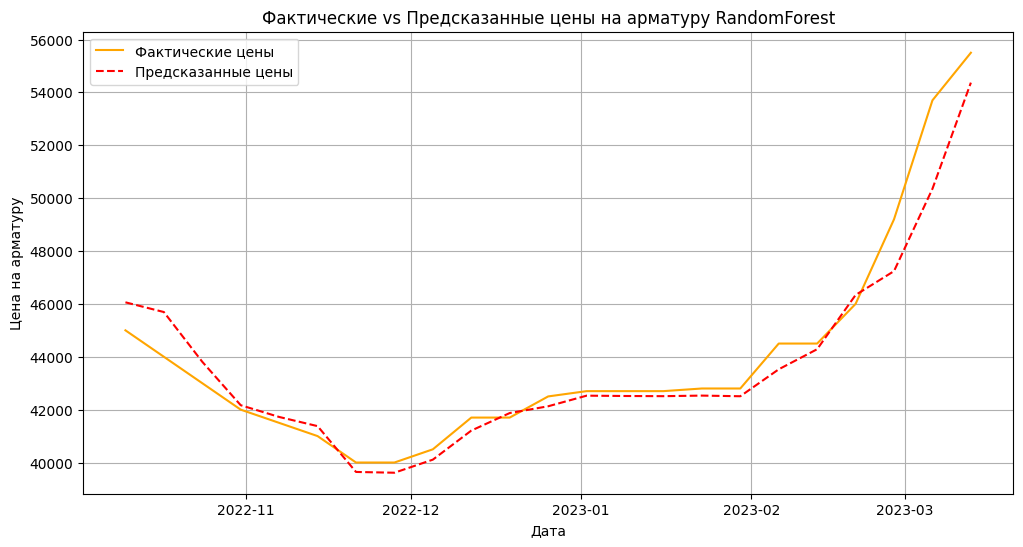

In [382]:
plt.figure(figsize=(12, 6))
plt.plot(test['dt'], y_test, label='Фактические цены', color='orange')
plt.plot(test['dt'].iloc[:len(y_pred)], y_pred, label='Предсказанные цены', color='red', linestyle='dashed')
plt.xlabel('Дата')
plt.ylabel('Цена на арматуру')
plt.title('Фактические vs Предсказанные цены на арматуру RandomForest')
plt.legend()
plt.grid()
plt.show()

### Смотрим результаты

##### Компоненты временных рядов

Кол-во наблюдений: 23
Кол-во NaN значений в тренде, после линейной интерполяцией: 0
Кол-во NaN значений в сезонности, после линейной интерполяцией: 0


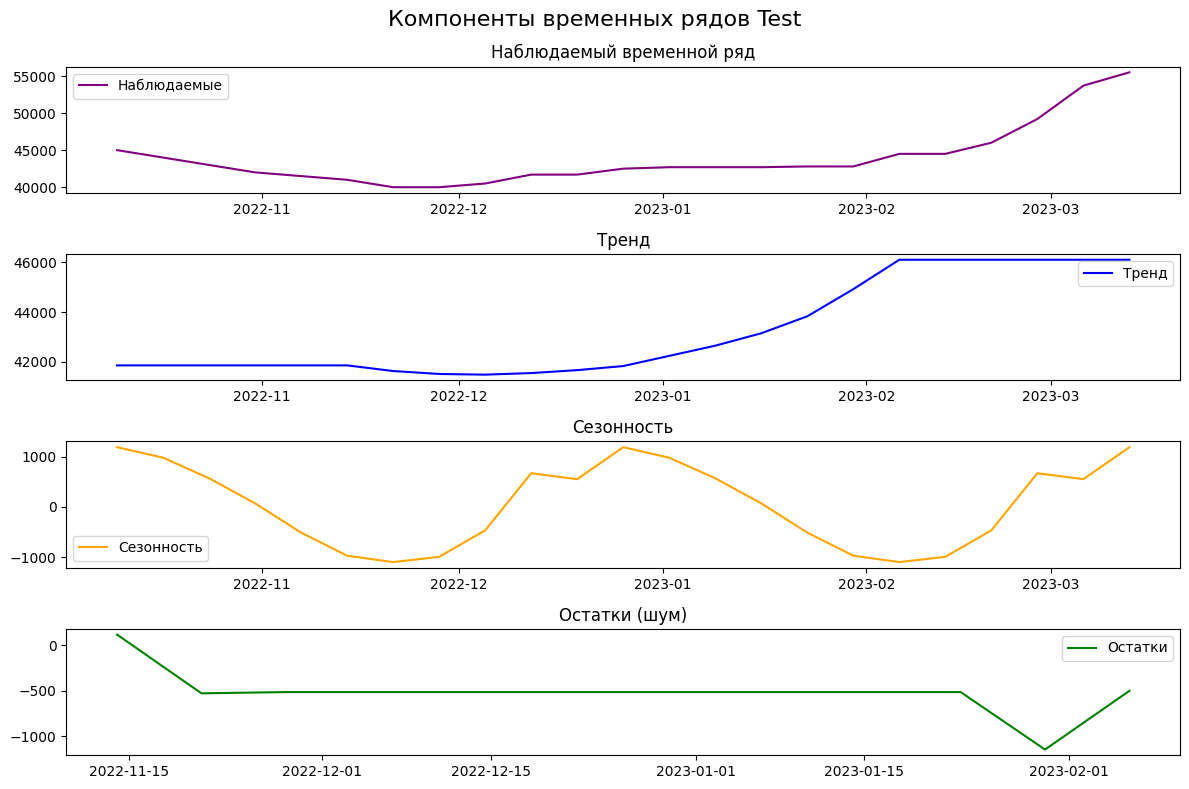

In [383]:
comp_vrem_ryadov(test, 11.5, 'Test', 0)

### Сохранение моделей

In [ ]:
# Сохранение CatBoost модели
with open('models/catboost_model.pkl', 'wb') as f:
      pickle.dump(grid_search_catboost.best_estimator_, f)

# Сохранение XGBoost модели
with open('models/xgboost_model.pkl', 'wb') as f:
      pickle.dump(grid_search_xgboost.best_estimator_, f)

# Сохранение RandomForest модели
with open('models/randomforest_model.pkl', 'wb') as f:
      pickle.dump(grid_search_rf.best_estimator_, f)

# Вернуть 'dt' как обычный столбец перед сохранением
test.reset_index(inplace=True)

# Сохранение обработанных тестовых данных
test.to_excel('data/test_prepared.xlsx', index=False)

### Вывод: Самая точная модель: CatBoost